In [25]:
!pip install seaborn
!pip install ipywidgets
!pip install -U scikit-learn


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [35]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_error
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GroupShuffleSplit, GridSearchCV

First, we'd like to import our files and join them together into one big file.


In [27]:
all_weeks_input = glob.glob("D:/2nd  year/1st term/Machine learning/project/nfl-big-data-bowl-2026-prediction/train/input_*.csv")
all_weeks_output = glob.glob("D:/2nd  year/1st term/Machine learning/project/nfl-big-data-bowl-2026-prediction/train/output_*.csv")
print(f'Input data for training consists of {len(all_weeks_input)} files.')
print(f'Output data for training consists of {len(all_weeks_output)} files.')
df_list_input = [pd.read_csv(f) for f in all_weeks_input]
df_list_output = [pd.read_csv(f) for f in all_weeks_output]
df_input0 = pd.concat(df_list_input, ignore_index=True)
df_output = pd.concat(df_list_output, ignore_index=True)


Input data for training consists of 18 files.
Output data for training consists of 18 files.


In [28]:

print("=" * 50)
print("         **** Input Datafram Info ****")
df_input0.info(show_counts=True)
print('Number of missing values in input file:')
df_input0.isnull().sum()

         **** Input Datafram Info ****
<class 'pandas.DataFrame'>
RangeIndex: 4880579 entries, 0 to 4880578
Data columns (total 23 columns):
 #   Column                    Non-Null Count    Dtype  
---  ------                    --------------    -----  
 0   game_id                   4880579 non-null  int64  
 1   play_id                   4880579 non-null  int64  
 2   player_to_predict         4880579 non-null  bool   
 3   nfl_id                    4880579 non-null  int64  
 4   frame_id                  4880579 non-null  int64  
 5   play_direction            4880579 non-null  object 
 6   absolute_yardline_number  4880579 non-null  int64  
 7   player_name               4880579 non-null  object 
 8   player_height             4880579 non-null  object 
 9   player_weight             4880579 non-null  int64  
 10  player_birth_date         4880579 non-null  object 
 11  player_position           4880579 non-null  object 
 12  player_side               4880579 non-null  object 
 13 

game_id                     0
play_id                     0
player_to_predict           0
nfl_id                      0
frame_id                    0
play_direction              0
absolute_yardline_number    0
player_name                 0
player_height               0
player_weight               0
player_birth_date           0
player_position             0
player_side                 0
player_role                 0
x                           0
y                           0
s                           0
a                           0
dir                         0
o                           0
num_frames_output           0
ball_land_x                 0
ball_land_y                 0
dtype: int64

In [29]:
print("=" * 50)
print("         **** Output Datafram Info ****")
df_output.info(show_counts=True)
print('Number of missing values in output file:')
df_output.isnull().sum()

         **** Output Datafram Info ****
<class 'pandas.DataFrame'>
RangeIndex: 562936 entries, 0 to 562935
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   game_id   562936 non-null  int64  
 1   play_id   562936 non-null  int64  
 2   nfl_id    562936 non-null  int64  
 3   frame_id  562936 non-null  int64  
 4   x         562936 non-null  float64
 5   y         562936 non-null  float64
dtypes: float64(2), int64(4)
memory usage: 25.8 MB
Number of missing values in output file:


game_id     0
play_id     0
nfl_id      0
frame_id    0
x           0
y           0
dtype: int64

So we can see that there are no missing values in our data which is quite a feat!

Some preliminary EDA to check the quality of the data:
 

In [30]:
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
display(df_input0.head())
display(df_input0.describe(include=[np.number]))
df_input0.nunique().sort_values() 


,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,player_birth_date,player_position,player_side,player_role,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
0,2023090700,101,False,54527,1,right,42,Bryan Cook,6-1,210,1999-09-07,FS,Defense,Defensive Coverage,52.33,36.94,0.09,0.39,322.40,238.24,21,63.259998,-0.22
1,2023090700,101,False,54527,2,right,42,Bryan Cook,6-1,210,1999-09-07,FS,Defense,Defensive Coverage,52.33,36.94,0.04,0.61,200.89,236.05,21,63.259998,-0.22
2,2023090700,101,False,54527,3,right,42,Bryan Cook,6-1,210,1999-09-07,FS,Defense,Defensive Coverage,52.33,36.93,0.12,0.73,147.55,240.60,21,63.259998,-0.22
3,2023090700,101,False,54527,4,right,42,Bryan Cook,6-1,210,1999-09-07,FS,Defense,Defensive Coverage,52.35,36.92,0.23,0.81,131.40,244.25,21,63.259998,-0.22
4,2023090700,101,False,54527,5,right,42,Bryan Cook,6-1,210,1999-09-07,FS,Defense,Defensive Coverage,52.37,36.90,0.35,0.82,123.26,244.25,21,63.259998,-0.22


,game_id,play_id,nfl_id,frame_id,absolute_yardline_number,player_weight,x,y,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y
count,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06,4.880579e+06
mean,2.023155e+09,2.196409e+03,4.955890e+04,1.613179e+01,6.055045e+01,2.112783e+02,6.050074e+01,2.681190e+01,3.019878e+00,2.118335e+00,1.804972e+02,1.815366e+02,1.164147e+01,6.051581e+01,2.663766e+01
std,2.011405e+05,1.246426e+03,5.210338e+03,1.113008e+01,2.305935e+01,2.217747e+01,2.348919e+01,1.000620e+01,2.227939e+00,1.415794e+00,1.007162e+02,9.800912e+01,5.331537e+00,2.529643e+01,1.543814e+01
min,2.023091e+09,5.400000e+01,3.084200e+04,1.000000e+00,1.100000e+01,1.530000e+02,4.100000e-01,6.200000e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,5.000000e+00,-5.260000e+00,-3.910000e+00
25%,2.023101e+09,1.150000e+03,4.519800e+04,8.000000e+00,4.100000e+01,1.950000e+02,4.263000e+01,1.899000e+01,1.090000e+00,1.010000e+00,9.091000e+01,9.174000e+01,8.000000e+00,4.261000e+01,1.330000e+01
50%,2.023111e+09,2.171000e+03,5.241300e+04,1.500000e+01,6.100000e+01,2.070000e+02,6.041000e+01,2.685000e+01,2.720000e+00,1.920000e+00,1.795600e+02,1.801400e+02,1.000000e+01,6.051000e+01,2.647000e+01
75%,2.023121e+09,3.246000e+03,5.450000e+04,2.200000e+01,8.000000e+01,2.250000e+02,7.823000e+01,3.462000e+01,4.620000e+00,3.040000e+00,2.708300e+02,2.715800e+02,1.400000e+01,7.847000e+01,3.987000e+01
max,2.024011e+09,5.258000e+03,5.667300e+04,1.230000e+02,1.090000e+02,3.580000e+02,1.198600e+02,5.288000e+01,1.253000e+01,1.712000e+01,3.600000e+02,3.600000e+02,9.400000e+01,1.258500e+02,5.733000e+01


player_to_predict               2
play_direction                  2
player_side                     2
player_role                     4
player_height                  16
player_position                19
num_frames_output              34
absolute_yardline_number       99
frame_id                      123
player_weight                 151
game_id                       272
s                            1033
a                            1105
player_birth_date            1132
player_name                  1383
nfl_id                       1384
play_id                      4317
ball_land_y                  5030
y                            5222
ball_land_x                  7491
x                           11872
dir                         36001
o                           36001
dtype: int64

# Filtering the data to only consider the data from the players to be predicted

In [31]:
df_input = df_input0[df_input0['player_to_predict'] == True].copy()
print(f'Filtered input shape: {df_input.shape}')

Filtered input shape: (1303440, 23)


In [32]:
shared_cols = set(df_input.columns) & set(df_output.columns)
print("Shared columns:", shared_cols)
merged_data = df_input.merge(
    df_output,
    on=['game_id', 'play_id', 'nfl_id', 'frame_id'],
    suffixes=('_input', '_output')
)

print(f'Merged data shape: {merged_data.shape}')
display(merged_data.head())

Shared columns: {'y', 'game_id', 'frame_id', 'nfl_id', 'play_id', 'x'}
Merged data shape: (560426, 25)


,game_id,play_id,player_to_predict,nfl_id,frame_id,play_direction,absolute_yardline_number,player_name,player_height,player_weight,player_birth_date,player_position,player_side,player_role,x_input,y_input,s,a,dir,o,num_frames_output,ball_land_x,ball_land_y,x_output,y_output
0,2023090700,101,True,46137,1,right,42,Justin Reid,6-1,204,1997-02-15,SS,Defense,Defensive Coverage,51.32,20.69,0.31,0.49,79.43,267.68,21,63.259998,-0.22,56.22,17.28
1,2023090700,101,True,46137,2,right,42,Justin Reid,6-1,204,1997-02-15,SS,Defense,Defensive Coverage,51.35,20.66,0.36,0.74,118.07,268.66,21,63.259998,-0.22,56.63,16.88
2,2023090700,101,True,46137,3,right,42,Justin Reid,6-1,204,1997-02-15,SS,Defense,Defensive Coverage,51.39,20.63,0.44,0.76,130.89,269.78,21,63.259998,-0.22,57.06,16.46
3,2023090700,101,True,46137,4,right,42,Justin Reid,6-1,204,1997-02-15,SS,Defense,Defensive Coverage,51.43,20.61,0.48,0.62,134.50,269.78,21,63.259998,-0.22,57.48,16.02
4,2023090700,101,True,46137,5,right,42,Justin Reid,6-1,204,1997-02-15,SS,Defense,Defensive Coverage,51.48,20.58,0.54,0.44,129.79,269.06,21,63.259998,-0.22,57.91,15.56


# Feature engineering and knn 

In [ ]:
# --- Merge (already done above) ---
# merged_data = df_input.merge(df_output, on=['game_id','play_id','nfl_id','frame_id'], suffixes=('_input','_output'))

# --- Robust height -> inches and BMI on merged_data ---
def height_to_inches(h):
    if pd.isna(h):
        return np.nan
    s = str(h)
    if '-' not in s:
        return np.nan
    ft, inch = s.split('-', 1)
    try:
        return int(ft) * 12 + int(inch)
    except ValueError:
        return np.nan

merged_data['player_height_in'] = merged_data['player_height'].apply(height_to_inches)
merged_data['bmi'] = (merged_data['player_weight'] / (merged_data['player_height_in']**2)) * 703

# --- Encode play direction (right=1, left=0) ---
merged_data['play_direction_encoded'] = (merged_data['play_direction'] == 'right').astype(int)

# --- Mirror BOTH input and output coordinates for left-moving plays ---
left_mask = (merged_data['play_direction'] == 'left')

# Long axis (0..120)
for col in ['x_input', 'ball_land_x', 'x_output']:
    merged_data.loc[left_mask, col] = 120.0 - merged_data.loc[left_mask, col]

# Short axis (0..53.3)
for col in ['y_input', 'ball_land_y', 'y_output']:
    merged_data.loc[left_mask, col] = 53.3 - merged_data.loc[left_mask, col]

# Angles (degrees)
merged_data.loc[left_mask, 'o']   = (merged_data.loc[left_mask, 'o']   + 180) % 360
merged_data.loc[left_mask, 'dir'] = (merged_data.loc[left_mask, 'dir'] + 180) % 360

# --- Distance to ball from mirrored input coordinates ---
merged_data['distance_to_ball'] = np.hypot(
    merged_data['x_input'] - merged_data['ball_land_x'],
    merged_data['y_input'] - merged_data['ball_land_y']
)

# --- Dummies on merged_data (so features line up) ---
position_dummies = pd.get_dummies(merged_data['player_position'], prefix='position')
role_dummies     = pd.get_dummies(merged_data['player_role'],     prefix='role')
merged_data = pd.concat([merged_data, position_dummies, role_dummies], axis=1)



Training set size: 449122
Validation set size: 111304
Target shape: (449122, 2)
Fitting 3 folds for each of 3 candidates, totalling 9 fits


KeyboardInterrupt: 

In [42]:
# --- Feature list that actually exists in merged_data ---
feature_columns = [
    'absolute_yardline_number',
    'x_input', 'y_input',
    's', 'a', 'dir', 'o',
    'num_frames_output',
    'ball_land_x', 'ball_land_y', 'player_weight',
    'player_height_in', 'bmi', 'distance_to_ball',
    'play_direction_encoded'
] + position_dummies.columns.tolist() + role_dummies.columns.tolist()

# --- Targets ---
y = merged_data[['x_output', 'y_output']].to_numpy()

# --- Basic sanity checks ---
missing_feats = [c for c in feature_columns if c not in merged_data.columns]
assert not missing_feats, f"Missing feature columns: {missing_feats}"

X = merged_data[feature_columns].fillna(0)

# --- Grouped split to avoid leakage (keep plays separate) ---
from sklearn.model_selection import GroupShuffleSplit
groups = merged_data['game_id'].astype(str) + '_' + merged_data['play_id'].astype(str)

gss = GroupShuffleSplit(test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(X, y, groups))

X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
y_train, y_val = y[train_idx], y[val_idx]

print(f"Training set size: {X_train.shape[0]}")
print(f"Validation set size: {X_val.shape[0]}")
print(f"Target shape: {y_train.shape}")

# --- KNN pipeline with scaling + grid search ---
from sklearn.pipeline import Pipeline
pipe = Pipeline(steps=[
    ('scaler', StandardScaler()),
    ('knn', MultiOutputRegressor(KNeighborsRegressor(weights='distance')))
])

param_grid = {'knn__estimator__n_neighbors': [20, 21, 22, 23, 24]}
grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring='neg_root_mean_squared_error',
    cv=3,
    verbose=1,
    n_jobs=-1
)
grid.fit(X_train, y_train)

best_k = grid.best_params_['knn__estimator__n_neighbors']
print(f"✅ Best k: {best_k}")

# --- Predict + metrics ---
y_pred = grid.predict(X_val)




Training set size: 449122
Validation set size: 111304
Target shape: (449122, 2)
Fitting 3 folds for each of 5 candidates, totalling 15 fits
✅ Best k: 24


📊 RMSE X: 5.589, RMSE Y: 4.866
📊 MAE  X: 4.230, MAE  Y: 3.657
⚙️ Combined RMSE (Euclid): 7.411


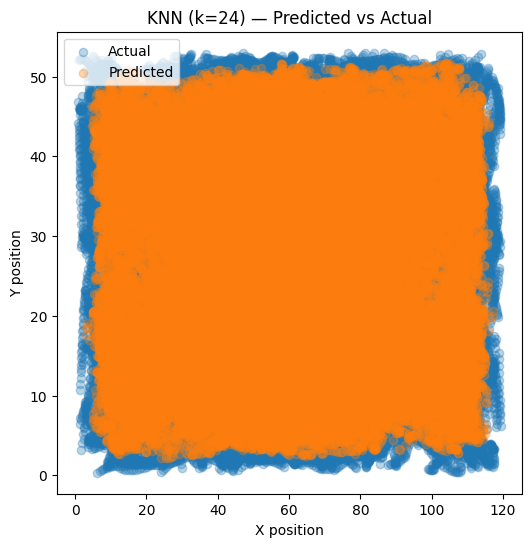

In [43]:
rmse_x = root_mean_squared_error(y_val[:, 0], y_pred[:, 0])
rmse_y = root_mean_squared_error(y_val[:, 1], y_pred[:, 1])
mae_x  = mean_absolute_error(y_val[:, 0], y_pred[:, 0])
mae_y  = mean_absolute_error(y_val[:, 1], y_pred[:, 1])

print(f"📊 RMSE X: {rmse_x:.3f}, RMSE Y: {rmse_y:.3f}")
print(f"📊 MAE  X: {mae_x:.3f}, MAE  Y: {mae_y:.3f}")
print(f"⚙️ Combined RMSE (Euclid): {np.hypot(rmse_x, rmse_y):.3f}")

plt.figure(figsize=(6,6))
plt.scatter(y_val[:,0], y_val[:,1], alpha=0.3, label='Actual')
plt.scatter(y_pred[:,0], y_pred[:,1], alpha=0.3, label='Predicted')
plt.xlabel('X position'); plt.ylabel('Y position')
plt.title(f'KNN (k={best_k}) — Predicted vs Actual')
plt.legend(); plt.show()

in order to consider that this is a time series and that close by frames are related, tried knn regression with lag


=== KNN comparison (same validation rows) ===
             Model  Best k   RMSE_X   RMSE_Y    MAE_X    MAE_Y  Combined_RMSE
     KNN (no lags)      24 5.777176 5.039438 4.384665 3.794574       7.666270
KNN (3-frame lags)      24 5.558530 5.201631 4.225776 3.939957       7.612767


c:\ProgramData\anaconda3\envs\APPY2025\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


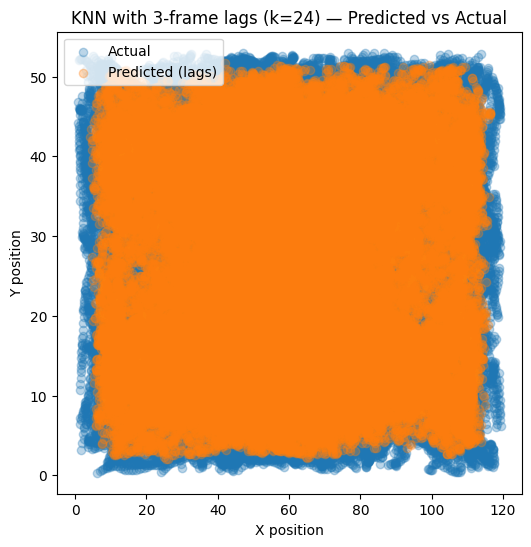

In [45]:
# ============================================================
# KNN: baseline (no lags) vs KNN with 3-frame lag features
# ============================================================

# 1) Build lag features on a sorted copy of merged_data
md_lag = merged_data.sort_values(['game_id', 'play_id', 'nfl_id', 'frame_id']).copy()

for lag in [1, 2, 3]:
    md_lag[f'x_input_lag{lag}'] = md_lag.groupby(['game_id','play_id','nfl_id'])['x_input'].shift(lag)
    md_lag[f'y_input_lag{lag}'] = md_lag.groupby(['game_id','play_id','nfl_id'])['y_input'].shift(lag)
    md_lag[f's_lag{lag}']       = md_lag.groupby(['game_id','play_id','nfl_id'])['s'].shift(lag)
    md_lag[f'a_lag{lag}']       = md_lag.groupby(['game_id','play_id','nfl_id'])['a'].shift(lag)
    md_lag[f'dir_lag{lag}']     = md_lag.groupby(['game_id','play_id','nfl_id'])['dir'].shift(lag)

# Keep only rows that have a full 3-frame history (you can require more lag cols if you like)
md_lag = md_lag.dropna(subset=['x_input_lag3', 'y_input_lag3', 's_lag3', 'a_lag3', 'dir_lag3']).copy()

# 2) Define features for both models on the SAME lag-filtered rows
#    (Baseline uses your original feature_columns; Lag model extends them.)
lag_cols = []
for lag in [1, 2, 3]:
    lag_cols += [f'x_input_lag{lag}', f'y_input_lag{lag}', f's_lag{lag}', f'a_lag{lag}', f'dir_lag{lag}']

feature_columns_no_lag = feature_columns[:]  # from your earlier code
feature_columns_lag = feature_columns_no_lag + lag_cols

missing_no_lag = [c for c in feature_columns_no_lag if c not in md_lag.columns]
missing_lag    = [c for c in feature_columns_lag if c not in md_lag.columns]
assert not missing_no_lag, f"Missing no-lag features: {missing_no_lag}"
assert not missing_lag,    f"Missing lag features: {missing_lag}"

X0   = md_lag[feature_columns_no_lag].fillna(0)
Xlag = md_lag[feature_columns_lag].fillna(0)
ylag = md_lag[['x_output','y_output']].to_numpy()

# 3) Grouped split (same seed) to avoid leakage and keep comparison fair
groups_lag = md_lag['game_id'].astype(str) + '_' + md_lag['play_id'].astype(str)
gss = GroupShuffleSplit(test_size=0.2, random_state=42)
train_idx, val_idx = next(gss.split(Xlag, ylag, groups_lag))

X0_tr, X0_va   = X0.iloc[train_idx],   X0.iloc[val_idx]
Xlg_tr, Xlg_va = Xlag.iloc[train_idx], Xlag.iloc[val_idx]
y_tr,  y_va    = ylag[train_idx],      ylag[val_idx]

# 4) Helper to train + tune a KNN pipeline and return metrics
def fit_knn_and_report(X_train, y_train, X_val, y_val, k_list=(22, 23, 24)):
    pipe = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('knn', MultiOutputRegressor(KNeighborsRegressor(weights='distance')))
    ])
    grid = GridSearchCV(
        estimator=pipe,
        param_grid={'knn__estimator__n_neighbors': list(k_list)},
        scoring='neg_root_mean_squared_error',
        cv=3,
        verbose=0,
        n_jobs=-1
    )
    grid.fit(X_train, y_train)
    best_k = grid.best_params_['knn__estimator__n_neighbors']
    y_pred = grid.predict(X_val)
    # Use mean_squared_error with squared=False for RMSE
    rmse_x = root_mean_squared_error(y_val[:,0], y_pred[:,0])
    rmse_y = root_mean_squared_error(y_val[:,1], y_pred[:,1])
    mae_x  = mean_absolute_error(y_val[:,0], y_pred[:,0])
    mae_y  = mean_absolute_error(y_val[:,1], y_pred[:,1])
    return {
        'model': grid,
        'best_k': best_k,
        'rmse_x': rmse_x,
        'rmse_y': rmse_y,
        'mae_x': mae_x,
        'mae_y': mae_y,
        'y_pred': y_pred
    }

# 5) Train/evaluate both models on the same rows
res_no_lag = fit_knn_and_report(X0_tr,  y_tr, X0_va,  y_va)
res_lag    = fit_knn_and_report(Xlg_tr, y_tr, Xlg_va, y_va)

# 6) Compare metrics
def row(name, res):
    return {
        'Model': name,
        'Best k': res['best_k'],
        'RMSE_X': res['rmse_x'],
        'RMSE_Y': res['rmse_y'],
        'MAE_X':  res['mae_x'],
        'MAE_Y':  res['mae_y'],
        'Combined_RMSE': np.hypot(res['rmse_x'], res['rmse_y'])
    }

summary = pd.DataFrame([
    row('KNN (no lags)', res_no_lag),
    row('KNN (3-frame lags)', res_lag)
])

print("\n=== KNN comparison (same validation rows) ===")
print(summary.to_string(index=False))

# 7) Quick scatter for the lag model (usually better)
plt.figure(figsize=(6,6))
plt.scatter(y_va[:,0], y_va[:,1], alpha=0.3, label='Actual')
plt.scatter(res_lag['y_pred'][:,0], res_lag['y_pred'][:,1], alpha=0.3, label='Predicted (lags)')
plt.xlabel('X position'); plt.ylabel('Y position')
plt.title(f'KNN with 3-frame lags (k={res_lag["best_k"]}) — Predicted vs Actual')
plt.legend(); plt.show()
